# Color-color Diagram with Contour Levels

Create a color color diagram that has contour levels as well


In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

### Define a function that creates jointplots

In [2]:
from matplotlib import gridspec
from scipy.stats import gaussian_kde

def jointPlot(data_1, data_2, dims,cols,bins,kde=False,**kwargs):
    '''
    data = our dataset - dimensions (:,2) or (:,4) depending on the dimension
    dims = 2 or 4 - 2 in case we have a joint plot of one type of data - 4 if we have two types of data
    cols = colors (1 or 2)
    '''
    # ============================================================
    # ============================================================
    # Define the max and mins of the first dataset
    x_min_1, x_max_1 = data_1[:,0].min(),data_1[:,0].max()
    y_min_1, y_max_1 = data_1[:,1].min(),data_1[:,1].max()
    
    # Now if dims = 4, find the min and max of the second dataset as well
    if (dims==4):
        x_min_2, x_max_2 = data_2[:,0].min(),data_2[:,0].max()
        y_min_2, y_max_2 = data_2[:,1].min(),data_2[:,1].max()
    
    # ============================================================
    # ============================================================
    # Define grid for subplots
    gs = gridspec.GridSpec(2, 2,wspace=0.2,hspace=0.2, width_ratios=[4, 1], height_ratios = [1, 4])
    
    # ============================================================
    # ============================================================
    #Create scatter plot
    fig = plt.figure(figsize=(5.5,5.5),facecolor='white')
    ax = plt.subplot(gs[1, 0],frameon = True)
    cax = ax.scatter(data_1[:,0], data_1[:,1],rasterized=True, color=cols[0], s=0.7, alpha=.6)
    # Now in case dims=4, add one more scatter plot
    if (dims==4):
        cax = ax.scatter(data_2[:,0], data_2[:,1], rasterized=True,color=cols[1], s=0.7, alpha=.6)
   
    ax.grid(ls='--', axis='both' ,alpha=0.7)
    
    ax.set_xlabel(kwargs['xlabel'],fontsize=13)
    ax.set_ylabel(kwargs['ylabel'],fontsize=13)
    # ===============================================================
    # ===============================================================
    # Lower and upper limits in the x and y directions
    x_low = kwargs['xlow']
    x_up = kwargs['xup']
    y_low = kwargs['ylow']
    y_up = kwargs['yup']
    # ===============================================================
    # ===============================================================
    #Create Y-marginal (right)
    axr = plt.subplot(gs[1, 1], sharey=ax, frameon = True, xticks = [],ylim=(y_low,y_up)) 
    axr.hist(data_1[:,1],bins=bins, color = 'forestgreen',alpha=0.9, orientation = 'horizontal', density = True)
    # In case dims = 4, add one more historgram
    if (dims==4):
        axr.hist(data_2[:,1],bins=bins, color = cols[1],alpha=0.6, orientation = 'horizontal', density = True)
        
    
    axr.grid(ls='--', axis='both' ,alpha=0.6)
    
    
    # ===============================================================
    #Create X-marginal(top)
    axt = plt.subplot(gs[0,0], sharex=ax,frameon = True, yticks=[],xlim=(x_low,x_up))
    axt.hist(data_1[:,0],bins=bins, color = 'forestgreen',alpha=0.9, density = True)
    # In case dims = 4, add one more histogram
    if (dims==4):
        axt.hist(data_2[:,0],bins=bins, color = cols[1],alpha=0.6, density = True)
        
    axt.grid(ls='--', axis='both' ,alpha=0.6)
    
    #Bring the marginals closer to the scatter plot
    fig.tight_layout(pad = 0.0)

    if kde:
        kdex_1=gaussian_kde(data_1[:,0])
        kdey_1=gaussian_kde(data_1[:,1])
        x_1= np.linspace(x_min_1,x_max_1,100)
        y_1= np.linspace(y_min_1,y_max_1,100)
        dx_1=kdex_1(x_1)
        dy_1=kdey_1(y_1)
        axr.plot(dy_1,y_1,color='k',linewidth=1.2)
        axt.plot(x_1,dx_1,color='k', linewidth=1.2)
        
        # And in case dims = 4, we have more kdes
        if (dims==4):
            kdex_2=gaussian_kde(data_2[:,0])
            kdey_2=gaussian_kde(data_2[:,1])
            x_2= np.linspace(x_min_2,x_max_2,100)
            y_2= np.linspace(y_min_2,y_max_2,100)
            dx_2=kdex_2(x_2)
            dy_2=kdey_2(y_2)
            axr.plot(dy_2,y_2,color='black', ls='--')
            axt.plot(x_2,dx_2,color='black', ls='--')
        
    return ax,axt,axr   

## First work for Galfit

### Import the catalog 

In [3]:
import pandas as pd

LSBG_df = pd.read_csv('LSBG_catalog.csv')

LSBG_df.head()

mag_g = LSBG_df['mag_gfm_g_corr'].values
mag_r = LSBG_df['mag_gfm_r_corr'].values
mag_i = LSBG_df['mag_gfm_i_corr'].values

#print(len(mag_g))

In [4]:
# Define the colors here
col_g_i = mag_g - mag_i
col_g_r = mag_g - mag_r
col_i_r = mag_i - mag_r


### Find dividing point between red/blue galaxies by fitting a Gaussian Mixture Model

In [5]:
from sklearn import mixture
color = col_g_i[(col_g_i>-0.5)&(col_g_i<1.5)&(col_g_r<1.2)]
np.random.seed(1)
g = mixture.GaussianMixture(n_components=2)
model_new = g.fit(color.reshape(-1, 1))

In [6]:
x = np.linspace(-0.5,1.5,1000)
logprob = g.score_samples(x.reshape(-1, 1))
responsibilities = g.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

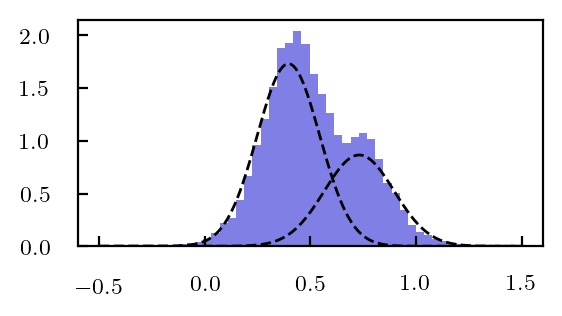

In [7]:
plt.figure(figsize = (3.,1.5))
plt.hist(color, bins=50, color='mediumblue',alpha=0.5, density=True)
plt.plot(x,pdf_individual[:,0],linewidth=1.0, c='k', ls='--')
plt.plot(x,pdf_individual[:,1],linewidth=1.0, c='k', ls='--')
#plt.savefig('GMM.png')
plt.show()

In [8]:
dif = pdf_individual[:,0] - pdf_individual[:,1]
med_g_i = x[(dif>-1e-2)&(dif<1e-2)&(x>0.5)&(x<1)]
print(med_g_i)

[0.60510511]


In [9]:
data_1 = np.zeros((len(col_g_i[(col_g_i>-1.0)&(col_g_i<1.5)&(col_g_r<1.2)]),2))
data_1[:,1] = col_g_r[(col_g_i>-1.0)&(col_g_i<1.5)&(col_g_r<1.2)]
data_1[:,0] = col_g_i[(col_g_i>-1.0)&(col_g_i<1.5)&(col_g_r<1.2)]

data_2 = np.zeros([2,2])

Make it having nice contour levels

In [10]:
# First I have to create a 2D histogram to get the values
n_x = 100
n_y = 100
x_vals = np.linspace(-0.3,1.5,n_x)
y_vals = np.linspace(-0.2,1.2,n_y)

Y, X = np.meshgrid(x_vals,y_vals)
xy = np.vstack([Y.ravel(),X.ravel()])

In [11]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=0.03, kernel='gaussian', metric='euclidean')
kde.fit(data_1)
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy.T))
Z = Z.reshape(X.shape)

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


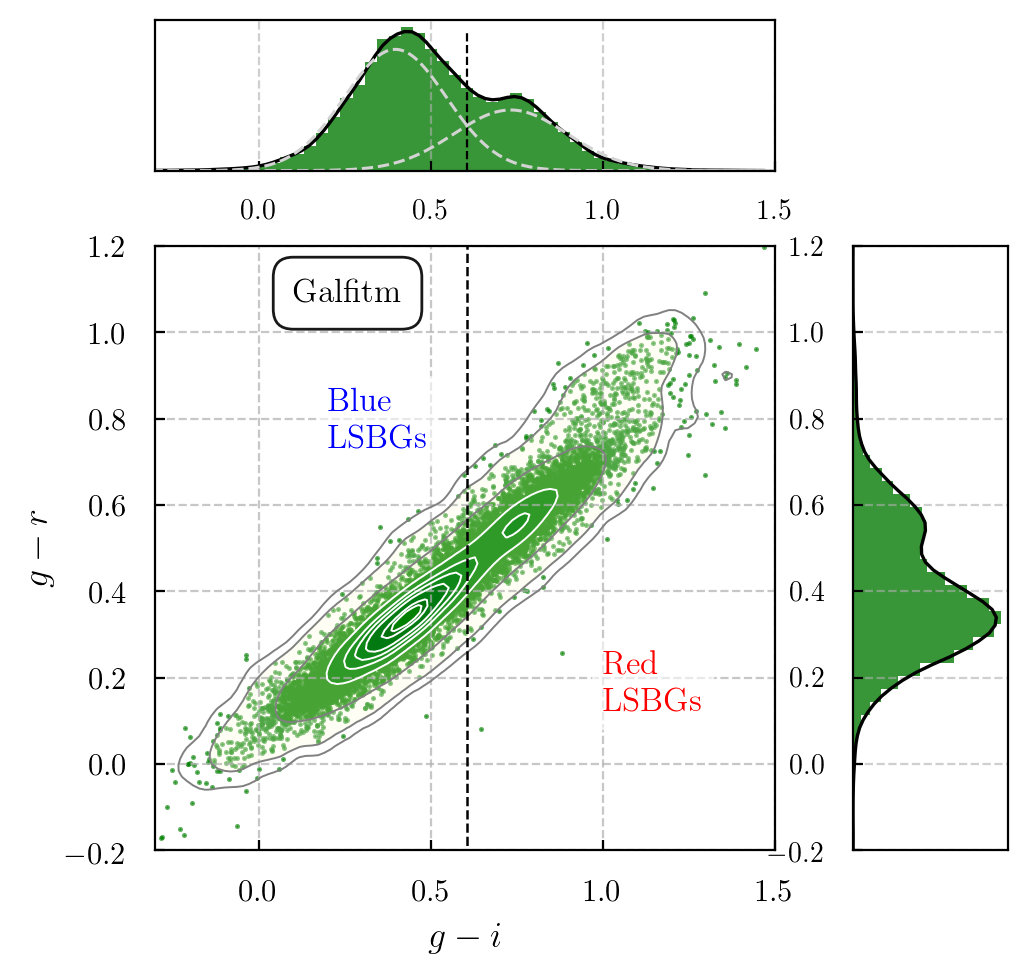

In [12]:
props = dict(boxstyle='round,pad=0.6', facecolor='white', alpha=0.9)
props_2 = dict(boxstyle='round', facecolor='white',edgecolor='white', alpha=0.6)

#sns.set(style='whitegrid',font='serif',rc={'text.usetex' : True})
#sns.set_style({'xtick.bottom': True, 'xtick.top': True})
# Return ax object for extras
ax,axt,axr = jointPlot(data_1,data_2, dims=2,cols=['g'],bins=60,kde=True,xlabel='$g-i$', ylabel='$g-r$', xlow=-0.3,xup=1.5,ylow=-0.2,yup=1.2)
levels = np.linspace(0.015, Z.max(),11)
levels = [0.03,0.1,1,5,8,10,12,15,16]
colors = ['gray','gray','gray','w','w','w','w','w','w']
CS = ax.contour(Y,X, Z, levels=levels,colors=colors,linewidths=0.7)
CS = ax.contourf(Y,X, Z, levels=levels[1:], alpha=0.3,cmap='YlGn')
ax.vlines(med_g_i,-0.25,1.25, color='k', linewidth=0.9,linestyle='--')
ax.text(0.2,0.73, 'Blue \n LSBGs', color='blue',bbox=props_2,fontsize=12)
ax.text(1.0,0.12, 'Red \n LSBGs', color='red',bbox=props_2,fontsize=12)

ax.text(0.10,1.07, 'Galfitm', color='k', bbox=props, fontsize=12)

axr.tick_params(axis='both', labelsize=10)
axt.tick_params(axis='both', labelsize=10)
axt.vlines(med_g_i,0.,2.0, color='k', linewidth=0.8,linestyle='--')
axt.plot(x,pdf_individual[:,0],linewidth=1.1, c='lightgray', ls='--')
axt.plot(x,pdf_individual[:,1],linewidth=1.1, c='lightgray', ls='--')
ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
plt.savefig('Color_color_Galfit.pdf', dpi=100)
plt.show()

In [13]:
print(np.max(Z))

17.00021832290955


#### Calculate median of the red and blue galaxy populations

In [14]:
med_red = np.median(col_g_i[col_g_i>med_g_i])
med_blue = np.median(col_g_i[col_g_i<med_g_i])

print('Median of the red population:')
print(med_red)
print('Median of the blue population')
print(med_blue)
# ======================================================
# ======================================================
# Now, also print the size of each of the two populations
print('red:',len(mag_g[col_g_i>med_g_i]))
print('blue:',len(mag_g[col_g_i<med_g_i]))

Median of the red population:
0.7592999999999996
Median of the blue population
0.4059360000000005
('red:', 7671)
('blue:', 16119)


## Now for SExtractor

In [15]:
mag_g_auto = LSBG_df['mag_auto_g_corr'].values
mag_r_auto = LSBG_df['mag_auto_r_corr'].values
mag_i_auto = LSBG_df['mag_auto_i_corr'].values

In [16]:
# Define the colors here
col_g_i = mag_g_auto - mag_i_auto
col_g_r = mag_g_auto - mag_r_auto
col_i_r = mag_i_auto - mag_r_auto

print(len(mag_g))

23790


In [17]:
color = col_g_i[(col_g_i>-0.5)&(col_g_i<1.5)&(col_g_r<1.2)]
np.random.seed(1)
g = mixture.GaussianMixture(n_components=2)
model_new = g.fit(color.reshape(-1, 1))

In [18]:
x = np.linspace(-0.5,1.5,1000)
logprob = g.score_samples(x.reshape(-1, 1))
responsibilities = g.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

#### Calculate and print the median of the $g-i$ color

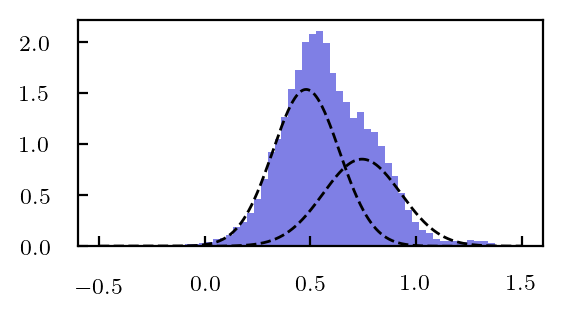

In [19]:
plt.figure(figsize = (3.,1.5))
plt.hist(color, bins=50, color='mediumblue',alpha=0.5, density=True)
plt.plot(x,pdf_individual[:,0],linewidth=1.0, c='k', ls='--')
plt.plot(x,pdf_individual[:,1],linewidth=1.0, c='k', ls='--')
plt.show()

In [20]:
dif = pdf_individual[:,0] - pdf_individual[:,1]
print(x[(dif>-1e-2)&(dif<1e-2)&(x>0.5)&(x<1)])

[0.66316316 0.66516517]


In [21]:
med_g_i = 0.66316316
data = np.zeros((len(col_g_i),2))
data[:,1] = col_g_r;data[:,0] = col_g_i

### KDE for contour levels

In [22]:
# First I have to create a 2D histogram to get the values
n_x = 100
n_y = 100
x_vals = np.linspace(-0.3,1.5,n_x)
y_vals = np.linspace(-0.2,1.2,n_y)

Y, X = np.meshgrid(x_vals,y_vals)
xy = np.vstack([Y.ravel(),X.ravel()])

In [23]:
kde = KernelDensity(bandwidth=0.03, kernel='gaussian', metric='euclidean')
kde.fit(data)
# Evaluate on the xy map 
Z = np.exp(kde.score_samples(xy.T))
Z = Z.reshape(X.shape)

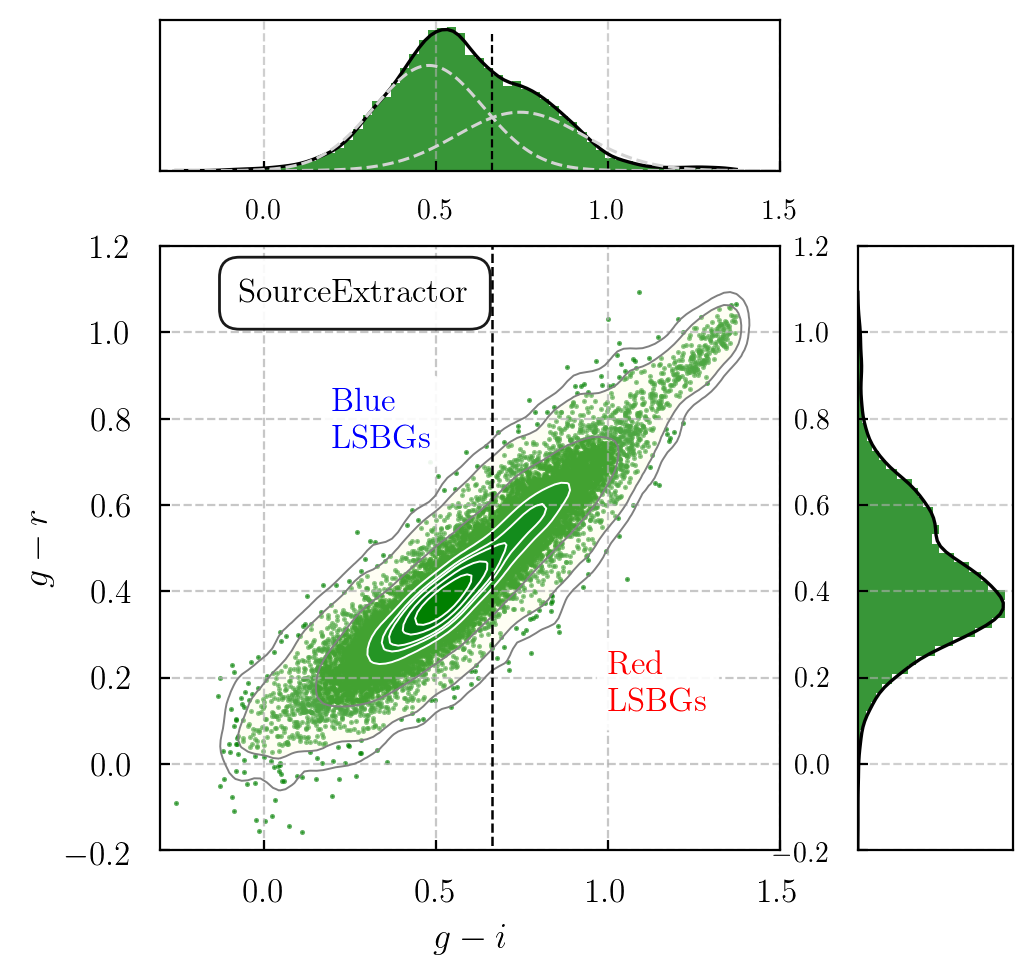

In [24]:
props_2 = dict(boxstyle='round', facecolor='white',edgecolor='white', alpha=0.9)

# Return ax object for extras
ax,axt,axr = jointPlot(data,data_2, dims=2,cols=['g'],bins=60,kde=True,xlabel='$g-i$', ylabel='$g-r$', xlow=-0.3,xup=1.5,ylow=-0.2,yup=1.2)

levels = np.linspace(0.015, Z.max(),11)
levels = [0.03,0.1,1,5,7,8,10,12]
colors = ['gray','gray','gray','w','w','w','w','w']
CS = ax.contour(Y,X, Z, levels=levels,colors=colors,linewidths=0.7)
CS = ax.contourf(Y,X, Z, levels=levels[1:], alpha=0.3,cmap='YlGn')


ax.vlines(med_g_i,-0.25,1.25, color='k', linewidth=0.9,linestyle='--')
ax.text(0.2,0.73, 'Blue \n LSBGs', color='blue',bbox=props_2,fontsize=12)
ax.text(1.0,0.12, 'Red \n LSBGs', color='red',bbox=props_2,fontsize=12)

ax.text(-0.07,1.07, 'SourceExtractor', color='k', bbox=props, fontsize=12)

axr.tick_params(axis='both', labelsize=10)
axt.tick_params(axis='both', labelsize=10)
ax.tick_params(axis='both', labelsize=12)

axt.vlines(med_g_i,0.,2.0, color='k', linewidth=0.8,linestyle='--')
axt.plot(x,pdf_individual[:,0],linewidth=1.1, c='lightgray', ls='--')
axt.plot(x,pdf_individual[:,1],linewidth=1.1, c='lightgray', ls='--')

plt.tight_layout()
plt.savefig('Color_color_SExtractor.pdf', dpi=100)
plt.show()

In [25]:
print(Z.max())

14.50825523744625
